In [89]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [90]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [91]:
np.random.seed(1337)
random.seed(1337)

Загрузка датасета

In [92]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
y = 2*y - 1

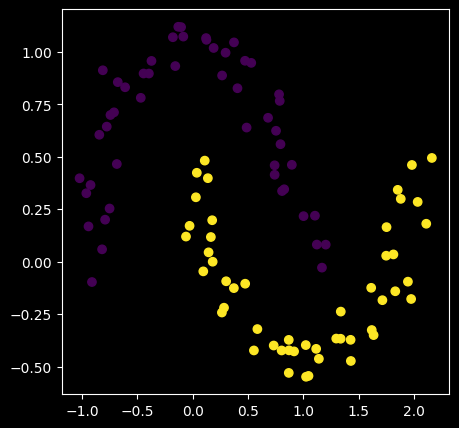

In [93]:
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [94]:
# 2 - кол-во входов, 16 16 скрытые слои, 1 - финальная выдача классификатора
model = MLP(2, [16, 16, 1])
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


Определение функции потерь

In [95]:
def loss(batch_size = None):

    # Внутренний кастомный DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        # Создание случайно перемешанного массива индексов от 0 до X.shape[0], получение :batch_size первых из них
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # Получение батча
        Xb = X[ri]
        yb = y[ri]

    # Применяю конструктор Value к каждой строке xrow в Xb, превращаю значения в Value
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # Forward pass инпутов через модель
    scores = list(map(model, inputs))

    # Формула функции потерь
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    # Усреднение на кол-во примеров
    data_loss = sum(losses) * (1.0 / len(losses))
    # Применение регуляризации
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Расчет accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [96]:
# Посмотреть на примере что делает конструктор
inputs = [list(map(Value, xrow)) for xrow in X]
inputs[:5]

[[Value: data=(1.1221146075409685), Value: data=(0.08147717341718697)],
 [Value: data=(-0.8188294130836691), Value: data=(0.058790063907949996)],
 [Value: data=(1.613709660987544), Value: data=(-0.12464590012238597)],
 [Value: data=(-0.9230091836872232), Value: data=(0.3652288989804421)],
 [Value: data=(0.14385146230962004), Value: data=(0.04438004920995997)]]

In [97]:
# Перфоманс модели на случайной инициализации, без тюнинга параметров
total_loss, accuracy = loss()
print(total_loss, accuracy)

Value: data=(1.1815924818239036) 0.5


### Optimization loop

In [98]:
def visualize_decision_boundary():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

step 0 loss 1.1816, accuracy 50.0%


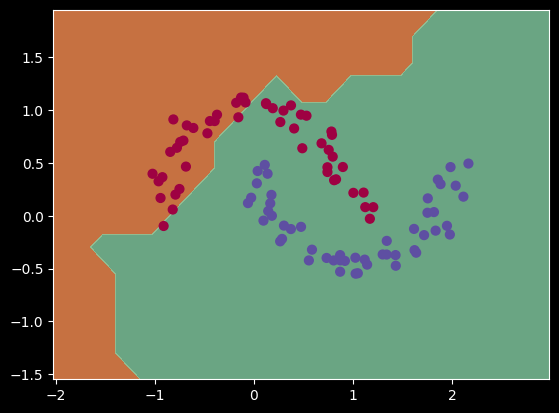

step 10 loss 0.5932, accuracy 87.0%


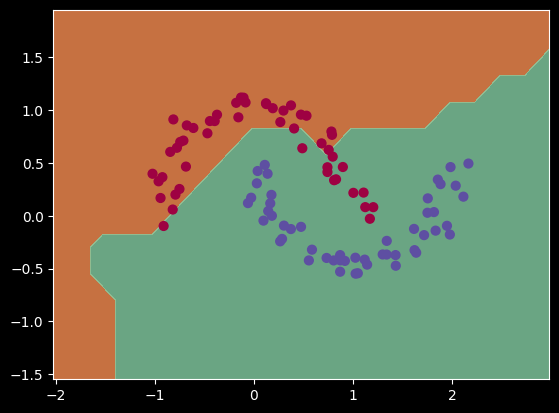

step 20 loss 0.5603, accuracy 88.0%


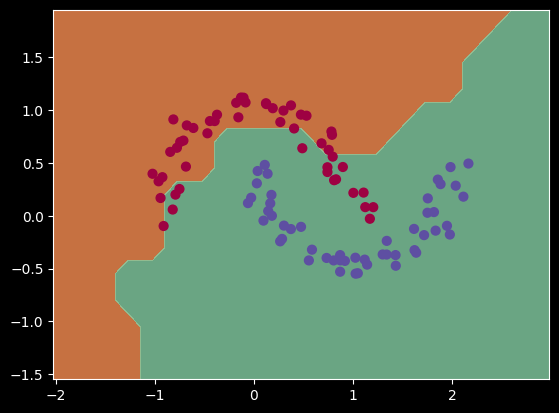

step 30 loss 0.5513, accuracy 85.0%


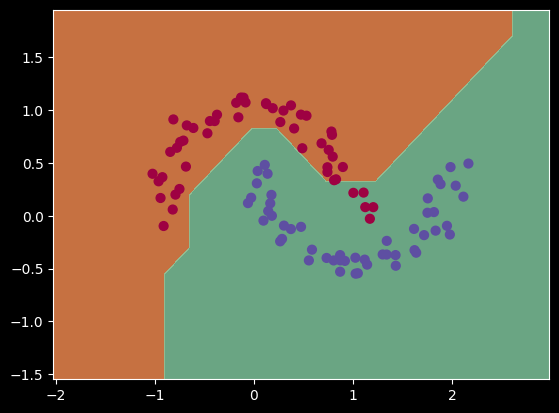

step 40 loss 0.5381, accuracy 90.0%


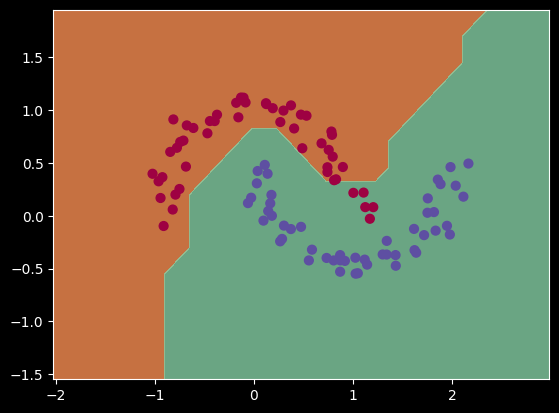

step 50 loss 0.5298, accuracy 92.0%


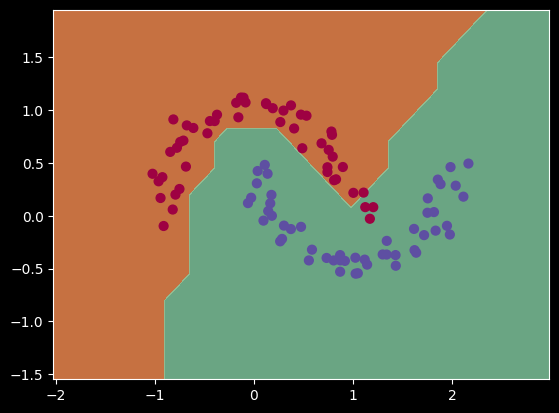

step 60 loss 0.5223, accuracy 96.0%


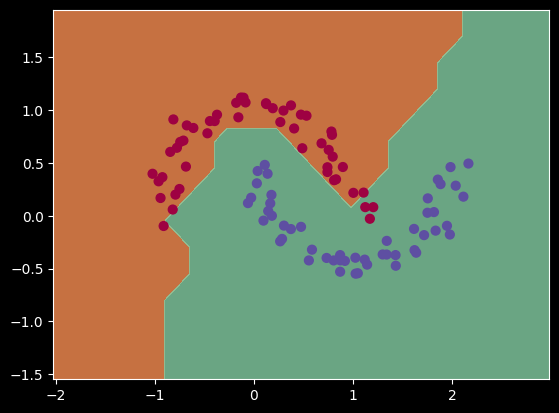

step 70 loss 0.5212, accuracy 97.0%


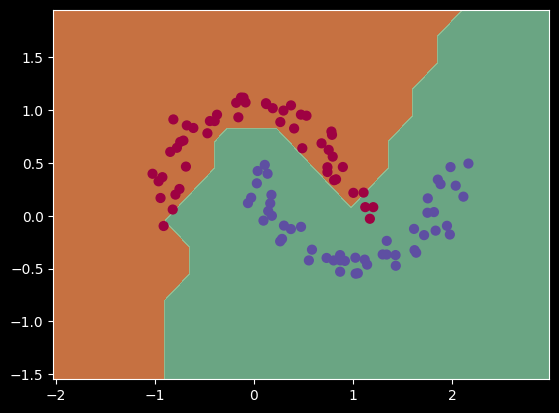

step 80 loss 0.5199, accuracy 97.0%


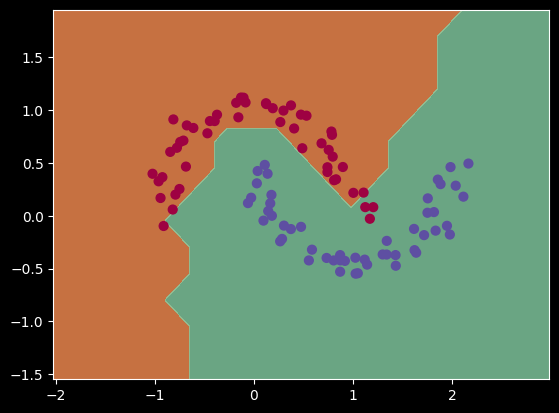

step 90 loss 0.5186, accuracy 97.0%


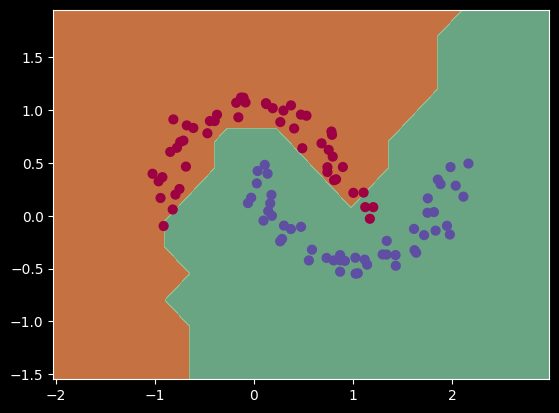

In [99]:
for k in range(100):

    total_loss, accuracy = loss()

    # Зануление градиентов
    model.zero_grad()
    # Расчет градиентов
    total_loss.backward()

    lr = 0.1
    for p in model.parameters():
        p.data -= lr * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data:.4f}, accuracy {accuracy*100}%")
        visualize_decision_boundary()
